#Implementation, Analysis, Performance Evaluation and Comparison of Deep Convolutional Neural Networks for Image Classification

**Objective:** The objective of this assignment is to implement a deep convolutional neural network (CNN) for the identification of flower types. The provided dataset consists of five classes of flowers, namely chamomile, tulip, rose, sunflower, and dandelion. 


**1. Prepare and Preprocess the data**


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
import seaborn as sns
from tensorflow.keras.regularizers import l1
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import os
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.metrics import confusion_matrix


In [3]:
#Step 1 implementation

dir_path = "/kaggle/input/flowers/flowers"
sub_folders = [i.path for i in os.scandir(dir_path) if i.is_dir()]
flowers = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
img_ext = ['.jpg', '.jpeg', '.png']
l = 0
for j in sub_folders:
    count = 0
    images = os.listdir(j)
    for k in images:
        if k.endswith('.jpg'):
            count += 1
    print(f'count of {flowers[l]} flower images is: {count}')
    l += 1

train_ds = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    validation_split=0.2,
    subset='training',
    label_mode='categorical',
    seed = 432,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    validation_split=0.2,
    subset='validation',
    label_mode='categorical',
    seed = 432,
    image_size=(224, 224),
    batch_size=32
)

#Hint: Take the help of split-folder python library

count of daisy flower images is: 1052
count of dandelion flower images is: 764
count of rose flower images is: 733
count of sunflower flower images is: 984
count of tulip flower images is: 784
Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


* What is the total number of images in the dataset, and how are they distributed across the five flower types?
>     The total images in the given Dataset are distributed accordingly:
count of daisy flower images is: 1052
count of dandelion flower images is: 764
count of rose flower images is: 733
count of sunflower flower images is: 984
count of tulip flower images is: 784
Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.
    
* Do we need to implement techniques to balance the distribution of images across various flower types, such as oversampling or undersampling?
> No implement any over or undersampling techniques for this distribution.

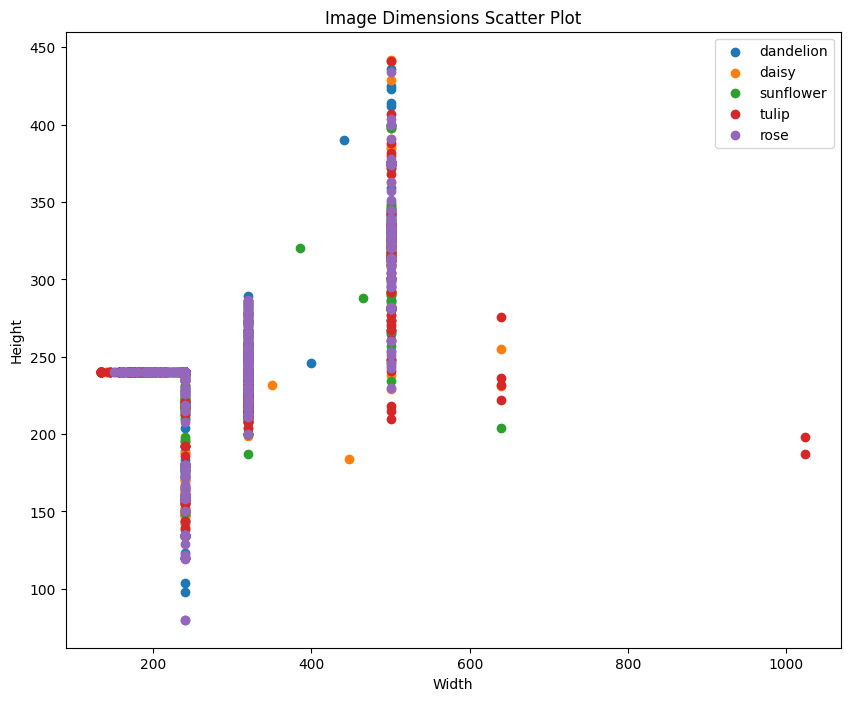

In [45]:
#Dimensions of all the images

main_folder = '/kaggle/input/flowers/flowers'

class_folders = [f.path for f in os.scandir(main_folder) if f.is_dir()]

# Function to get image dimensions from a folder
def get_image_dimensions(folder):
    dimensions = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    width, height = img.size
                    dimensions.append((width, height))
    return dimensions

# Create a scatter plot for each class
plt.figure(figsize=(10, 8))

for class_folder in class_folders:
    class_name = os.path.basename(class_folder)
    image_dimensions = get_image_dimensions(class_folder)
    widths, heights = zip(*image_dimensions)
    plt.scatter(widths, heights, label=class_name)

plt.title('Image Dimensions Scatter Plot')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend()
plt.show()


* What are the dimensions (height and width) of the images in the dataset, and is there any variation among different flower types?
> The graph above illustrates the dimensions of each image in every class. To address the question, it's evident that both within and across classes, the dimensions vary. Therefore, it becomes necessary to apply certain pre-processing techniques to prepare the input in a manner compatible with the mode 
* What preprocessing techniques should be applied, such as resizing, normalization or standardization and why?
> During the learning process, this method aids the optimization algorithm in more efficiently determining the minimum value of the cost function. In the realm of image data and Convolutional Neural Networks (CNNs), normalizing pixel values is a common practice. Normalization serves several purposes, such as stabilizing the learning process, expediting convergence, avoiding numerical instability, fortifying network robustness, and enhancing generalization. The latter is particularly crucial, as normalization facilitates the model in generalizing patterns to new, previously unseen data and mitigates excessive sensitivity to changes in the input data. In this specific instance, the data range is normalized from [0,255] to [0,1].
* How would you split the dataset into training, validation and testing sets, and in what ratios?
> In the context of training and testing, it's typical to select a split ratio of 80-20% or 70-30%, contingent upon the available data volume. Nevertheless, this ratio may be adjusted based on factors such as model complexity, the nature of the problem, and the quantity of available data. In our specific case, we had an ample amount of data, and the model's complexity varied during further analysis. Therefore, we made the decision to consistently maintain the general ratio of 80-20% throughout the assignment to facilitate result comparisons.


In [4]:
normalization = tf.keras.layers.Rescaling(1./255)

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = train_ds.map(lambda x,y : (normalization(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x,y : (normalization(x), y), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)


**2. Implement the given CNN architecture. Make necessary changes in the final layers for it to work on the number of classes in the given dataset. Use an input image size of $224 \times 224 \times 3$**
<img src='CNN.png' alt='given CNN'>

In [5]:
#Step 2 implementation
def my_cnn_model(input_shape=(224, 224, 3), num_classes=5):
    
    model = Sequential()

    # First Block
    model.add(Conv2D(64, (3, 3), activation='selu', padding='same', input_shape=input_shape, kernel_initializer = 'HeNormal'))
    model.add(Conv2D(64, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # 2nd Block
    model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # 3rd Block
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # 4th Block
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # 5th Block
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Final FC Block
    model.add(Flatten())
    model.add(Dense(4096, activation='selu', kernel_initializer = 'HeNormal'))
    model.add(Dense(4096, activation='selu', kernel_initializer = 'HeNormal'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

my_model = my_cnn_model()
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

**3. Train the model** 


* What is your approach for selecting the appropriate hyperparameters for the model training, such as the learning rate, number of epochs, batch size, and optimizer?
> The batch size has a notable impact on training speed and memory consumption. Smaller batch sizes lead to more frequent updates but may introduce noisier gradients. On the other hand, larger batch sizes generate more stable gradients but necessitate greater memory resources. Adjusting the number of epochs is contingent upon changes in model accuracy. If there's a significant shift in accuracy, increasing or decreasing the number of epochs can be a prudent choice.

When it comes to optimizers and learning rates, it is advisable to begin with the default learning rate values for commonly used optimizers like ADAM, which employ adaptive learning rates.

* What methods do you use for monitoring the training progress and performance of the model and why?
> In this scenario, we are evaluating the model's performance by examining key metrics such as accuracy and loss through training and validation curves. These curves provide insights into the training patterns and how well the model is learning.

Additionally, employing a confusion matrix allows us to visualize the correct classification of predicted and actual classes. This matrix provides a detailed breakdown of the model's performance, showcasing instances of true positives, true negatives, false positives, and false negatives, which is valuable for a comprehensive assessment of classification performance.

* What metrics would you prefer to measure the performance, such as accuracy, precision, recall, F1 score, or ROC-AUC and why?
> In our specific case, using accuracy as an indicator appears reasonable since it seems close enough to consider the classes balanced. However, there's a slight imbalance in the classes. In situations where the class distribution is uneven, it is advisable to consider other indicators such as Precision, Recall, and F1-Score. By consistently monitoring these metrics during training, you can obtain a more nuanced understanding of the model's progress and performance, especially in scenarios where class imbalances may impact the overall evaluation.

In [47]:
#Step 3 implementation

my_model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

#Training our model
train_model = my_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=20, 
    batch_size=32, 
)


Epoch 1/20
108/108 [==============================] - 33s 251ms/step - loss: 8.8009 - accuracy: 0.2085 - precision: 0.2154 - recall: 0.1676 - auc: 0.5088 - val_loss: 2.3367 - val_accuracy: 0.2236 - val_precision: 0.2236 - val_recall: 0.2236 - val_auc: 0.5139
Epoch 2/20
108/108 [==============================] - 27s 248ms/step - loss: 2.2184 - accuracy: 0.2099 - precision: 0.2124 - recall: 0.0825 - auc: 0.5031 - val_loss: 1.9500 - val_accuracy: 0.2387 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5348
Epoch 3/20
108/108 [==============================] - 27s 248ms/step - loss: 2.6653 - accuracy: 0.2096 - precision: 0.2099 - recall: 0.1381 - auc: 0.5079 - val_loss: 2.0422 - val_accuracy: 0.2236 - val_precision: 0.2236 - val_recall: 0.2236 - val_auc: 0.5365
Epoch 4/20
108/108 [==============================] - 27s 248ms/step - loss: 2.2620 - accuracy: 0.2027 - precision: 0.1980 - recall: 0.1008 - auc: 0.5046 - val_loss: 2.7416 - val_accuracy: 0.2387 - val_precision: 0.

In [7]:
eval_result = my_model.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

#Obtain the classification report
y_test_pred = my_model.predict(val_ds, verbose=0)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

true_labels = []
for _, label in val_ds:
    true_labels.extend(np.argmax(label.numpy(), axis=1))
print("\nClassification Report:")
print(classification_report(true_labels, y_test_pred_classes))

Validation Loss: 1.8092859983444214, Validation Accuracy: 0.3174971044063568

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.19      0.29       147
           1       0.72      0.07      0.12       193
           2       0.00      0.00      0.00       168
           3       0.64      0.25      0.36       149
           4       0.27      0.95      0.42       206

    accuracy                           0.32       863
   macro avg       0.44      0.29      0.24       863
weighted avg       0.43      0.32      0.24       863




ROC-AUC Score: 0.7431559028296293


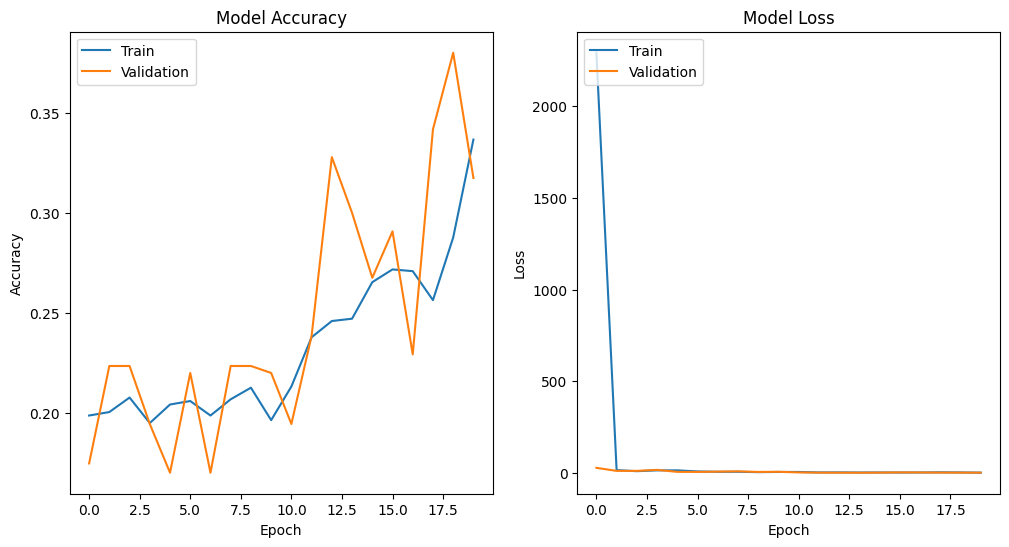

In [8]:
#ROC - AUC 
true_labels_categorical = to_categorical(true_labels, num_classes=5)

roc_auc = roc_auc_score(true_labels_categorical, y_test_pred, multi_class='ovr')
print(f"\nROC-AUC Score: {roc_auc}")

#Progress of our model Training

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**4. Report the results**


* What is the final accuracy of the model on the validation set, and how does it compare to the training accuracy?
> The situation you've described suggests that there might be a bias in the model towards one particular class. Even though both training and validation accuracies are at 21%, the fact that the accuracy is nearly 20% in a classification task with five classes implies that the model is predominantly predicting one class regardless of the input.

To address this bias, it's essential to investigate the data distribution and potential class imbalances. Additionally, adjusting the model architecture, optimizing hyperparameters, or employing techniques like class weighting can help mitigate bias and improve the model's ability to generalize across all classes. Regular monitoring of precision, recall, and F1-Score for each class can provide further insights into the model's behavior and aid in fine-tuning to achieve a more balanced performance across all classes.

* What is the confusion matrix for the model on the validation set, and which flower types are the most difficult to classify?
> The confusion matrix you've plotted indicates that the model tends to assign a majority of inputs to a specific class, essentially classifying many images into that particular category. This observation aligns with the difficulty the model faces in correctly classifying flowers other than tulips. The imbalanced distribution of predictions across different classes, particularly favoring one class, underscores the need for further investigation and potential adjustments to address the model's bias.

To enhance the model's performance on flowers other than tulips, considerations such as data augmentation, class balancing techniques, or fine-tuning the model architecture may be beneficial. Regularly assessing the confusion matrix and adjusting the model accordingly can contribute to more accurate and balanced predictions across all classes.

* How does the model perform on individual flower types, and are there any particular images that the model struggles to classify?
> The analysis of the confusion matrix suggests a notable bias in the model towards one specific class, making it challenging for the model to correctly classify flowers unless they belong to the tulip class. The frequent misclassification of all other flower classes indicates a need for addressing this bias and improving the model's ability to recognize a broader range of floral types.

Potential strategies to rectify this issue include investigating and addressing class imbalances in the training data, adjusting the model architecture or hyperparameters, and employing techniques like data augmentation to enhance the model's generalization across diverse flower categories. Regularly assessing and refining the model based on performance metrics and the confusion matrix can contribute to achieving a more balanced and accurate classification across all classes.


* What is the rough model complexity?
> =================================================================
Total params: 134281029 
Trainable params: 134281029 

* Is the model's large size contributing to any challenges or constraints in its performance on the given dataset.
> You've highlighted a crucial aspect of model complexity and training challenges. Larger models indeed come with more parameters to tune, making training more difficult and time-consuming. In situations where the dataset is limited, it can be challenging to leverage the benefits of larger models effectively.

Given the constraints, focusing on parameter tuning and applying techniques like regularization and batch normalization to enhance model performance is a pragmatic approach. These techniques can help mitigate overfitting, stabilize training, and improve the model's ability to generalize from limited data.

Moreover, you rightly point out that larger models tend to be more complex, making their decisions harder to interpret. If interpretability is a priority, opting for a simpler model may be a better choice, as it often results in more transparent and understandable decision-making processes. It's a thoughtful trade-off between model complexity, training feasibility, and interpretability, considering the specific constraints and goals of the task at hand.

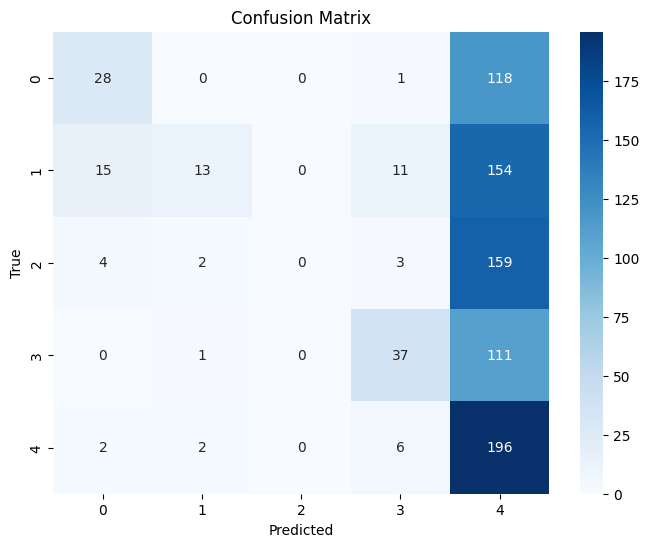

In [9]:
#Step 4 implementation

cm = confusion_matrix(true_labels, y_test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**5. Test the model by giving it a picture taken**


In [10]:
#Step 5 implementation
my_image = tf.io.read_file('/kaggle/input/my-roses/50ffb449e9d8ddc169ea63c2f1e621bd.jpg')
my_image = tf.image.decode_jpeg(my_image, channels = 3)
my_image = normalization(my_image)
my_image = tf.image.resize(my_image, (224,224))
my_image = tf.expand_dims(my_image, axis = 0)
my_pred = my_model.predict(my_image)
my_pred_class = np.argmax(my_pred)
print(f'The given image is of {flowers[my_pred_class]} class')

1/1 [==============================] - 0s 414ms/step
The given image is of tulip class


* How can the accuracy of the model on the picture taken by your own phone camera be evaluated?
> In the context of evaluating the accuracy for a single image classification, there are only two possible outcomes: either the model correctly classifies the image (resulting in 100% accuracy) or it misclassifies the image (resulting in 0% accuracy). This binary nature of accuracy calculation for individual images is a straightforward way to assess the model's performance on a per-instance basis. It's essential to consider this when dealing with single instances, as the concept of accuracy is inherently binary in such cases.

* What can be done if the model does not perform well on the picture taken by your own phone camera?
> The bias toward the tulip class and the misclassification of rose images into the tulip class indicate that the output values from the activation function are heavily skewed. Batch normalization is indeed a valuable technique in such cases.

Batch normalization helps normalize the outputs of the activation function, preventing extreme values that can lead to biases and difficulties in training. It can enhance the stability and performance of the model by mitigating issues related to internal covariate shifts.

Incorporating batch normalization into the model could contribute to a more balanced learning process, potentially reducing the bias towards certain classes and improving overall classification accuracy. Experimenting with batch normalization and monitoring its impact on the model's behavior would be a worthwhile step in refining the performance of your model.


**6. Use the same architecture but now train two different models one with L1 or L2 regularization, and one with batch normalization. (20 points)**


* Based on the results of the regularized and batch normalized models, how effective are L1 or L2 regularization and batch normalization techniques? How do they impact the model's performance, convergence, size, and inference time?

* How do the learned weights of the L1 or L2 regularized models compare to the baseline model? Provide any insights on the differences in the learned weights and what it implies for the model's performance and interpretability?

* What insights can be drawn from the comprehensive analysis of the regularized and batch normalized models regarding the use of regularization and normalization techniques in training machine learning models?

In [48]:
tf.keras.backend.clear_session()

In [12]:
#Step 6 implementation
#Using L1 Regularizer


def my_cnn_model_with_l1(input_shape=(224, 224, 3), num_classes=5, l1_reg=0.01):
    
    model = Sequential()

    # First Block
    model.add(Conv2D(64, (3, 3), activation='selu', padding='same', input_shape=input_shape, kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(Conv2D(64, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # 2nd Block
    model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # 3rd Block
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # 4th Block
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # 5th Block
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Final FC Block
    model.add(Flatten())
    model.add(Dense(4096, activation='selu', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(Dense(4096, activation='selu', kernel_regularizer=l1(l1_reg), kernel_initializer = 'HeNormal'))
    model.add(Dense(num_classes, activation='softmax'))

    return model
my_model_with_l1 = my_cnn_model_with_l1()
my_model_with_l1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [49]:
my_model_with_l1.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

#Training our model
train_model_with_l1 = my_model_with_l1.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    batch_size = 32,
)


Epoch 1/50
108/108 [==============================] - 36s 264ms/step - loss: 2910.0200 - accuracy: 0.2177 - precision: 0.2115 - recall: 0.1514 - auc: 0.5144 - val_loss: 1682.1943 - val_accuracy: 0.2387 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5507
Epoch 2/50
108/108 [==============================] - 28s 259ms/step - loss: 1328.5919 - accuracy: 0.2038 - precision: 0.2105 - recall: 0.0649 - auc: 0.4964 - val_loss: 1108.2883 - val_accuracy: 0.2596 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5642
Epoch 3/50
108/108 [==============================] - 28s 259ms/step - loss: 1011.1368 - accuracy: 0.2131 - precision: 0.2057 - recall: 0.0232 - auc: 0.5115 - val_loss: 934.7469 - val_accuracy: 0.2236 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5517
Epoch 4/50
108/108 [==============================] - 28s 260ms/step - loss: 882.6316 - accuracy: 0.2151 - precision: 0.2040 - recall: 0.0237 - auc: 0.5109 - val_loss: 837.1412 - val

In [14]:
eval_result_l1 = my_model_with_l1.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

#Obtain the classification report
y_test_pred_l1 = my_model_with_l1.predict(val_ds, verbose=0)
y_test_pred_classes_l1 = np.argmax(y_test_pred_l1, axis=1)

true_labels_l1 = []
for _, label in val_ds:
    true_labels_l1.extend(np.argmax(label.numpy(), axis=1))
print("\nClassification Report:")
print(classification_report(true_labels_l1, y_test_pred_classes_l1))

Validation Loss: 1.8092859983444214, Validation Accuracy: 0.3174971044063568

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.03      0.06       147
           1       0.23      0.86      0.37       193
           2       0.00      0.00      0.00       168
           3       0.55      0.49      0.52       149
           4       0.00      0.00      0.00       206

    accuracy                           0.28       863
   macro avg       0.23      0.28      0.19       863
weighted avg       0.21      0.28      0.18       863




ROC-AUC Score: 0.6845876274167735


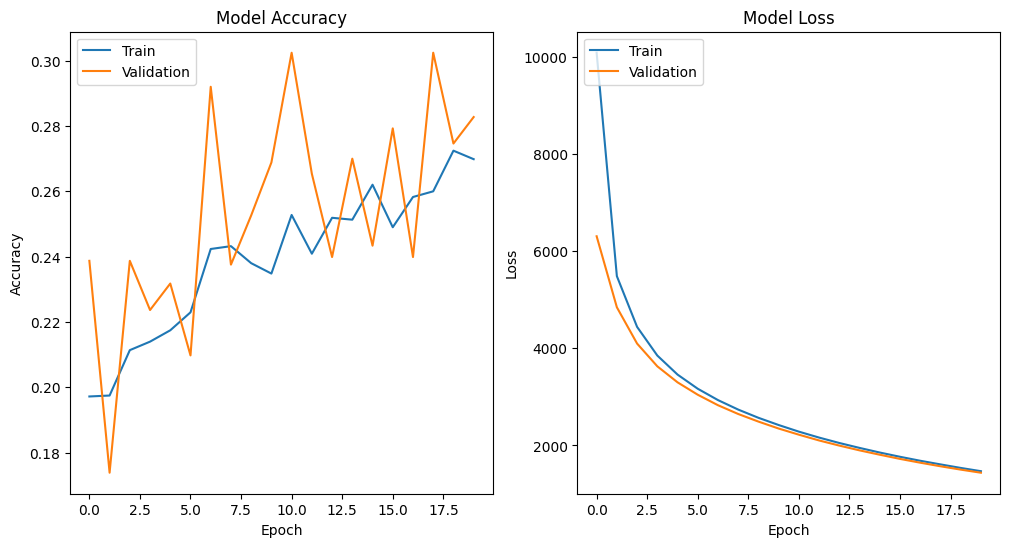

In [15]:
#ROC - AUC 
true_labels_categorical_l1 = to_categorical(true_labels_l1, num_classes=5)

roc_auc_l1 = roc_auc_score(true_labels_categorical_l1, y_test_pred_l1, multi_class='ovr')
print(f"\nROC-AUC Score: {roc_auc_l1}")

#Progress of our model Training

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(train_model_with_l1.history['accuracy'])
plt.plot(train_model_with_l1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_model_with_l1.history['loss'])
plt.plot(train_model_with_l1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

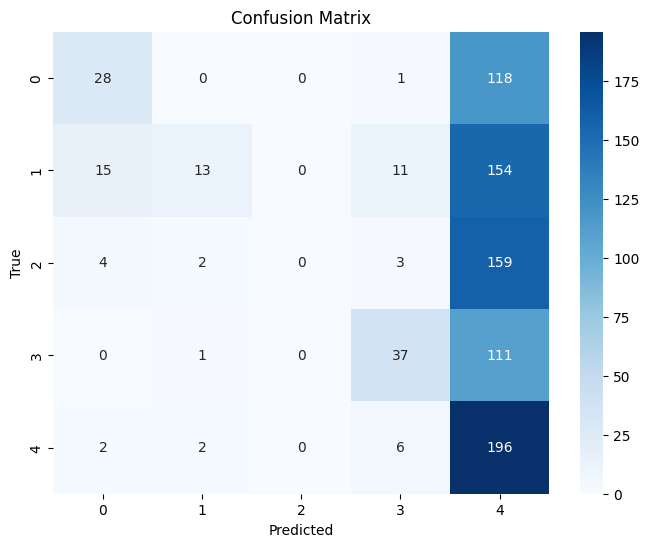

In [16]:

cm = confusion_matrix(true_labels_l1, y_test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels_l1), yticklabels=np.unique(true_labels_l1))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

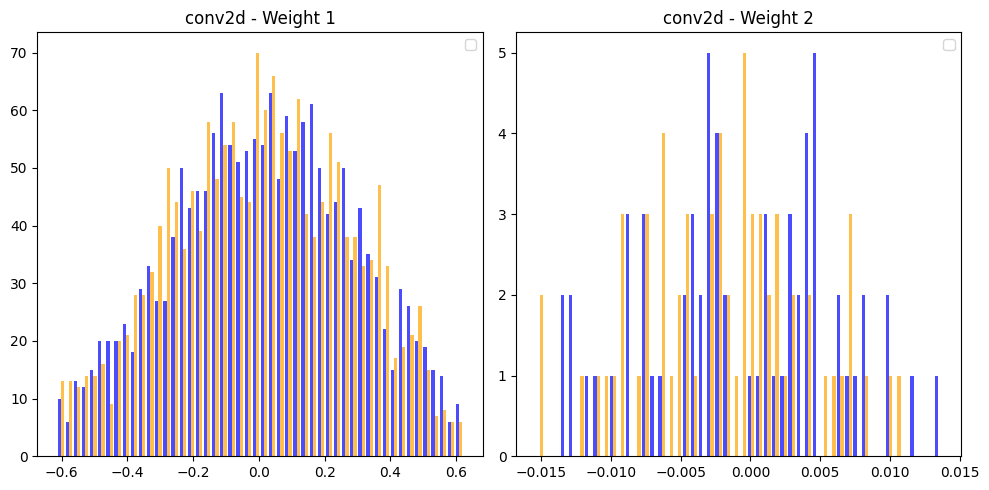

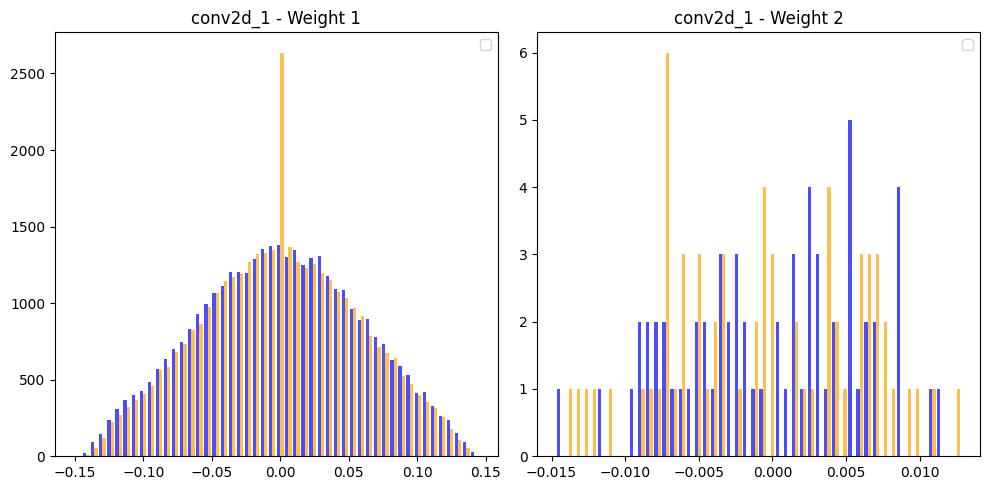

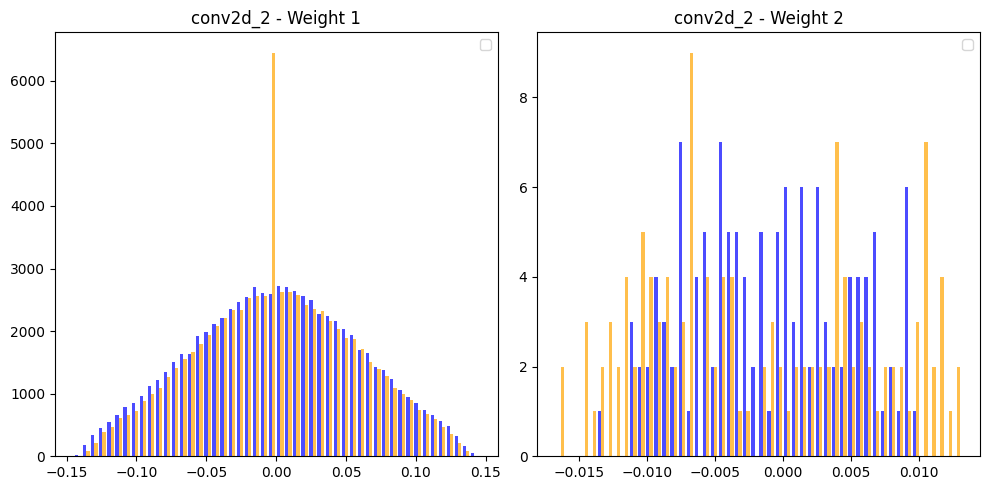

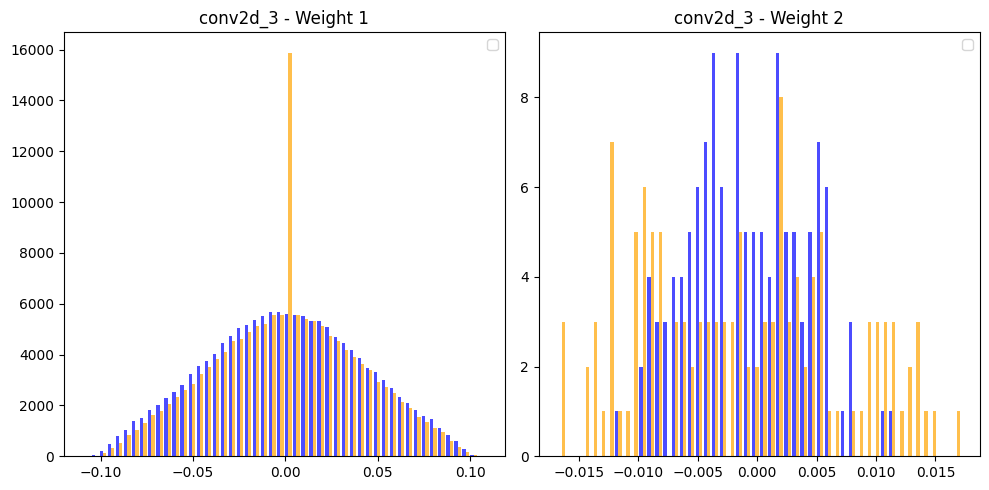

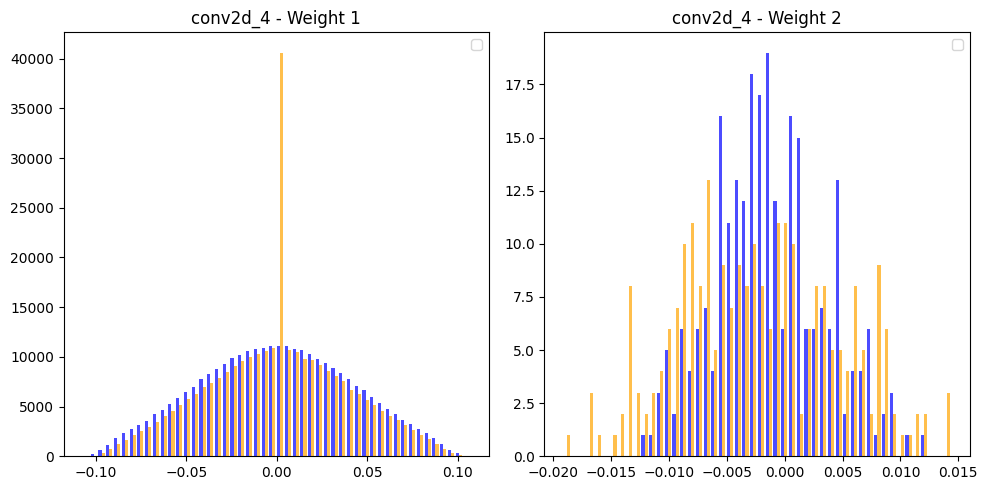

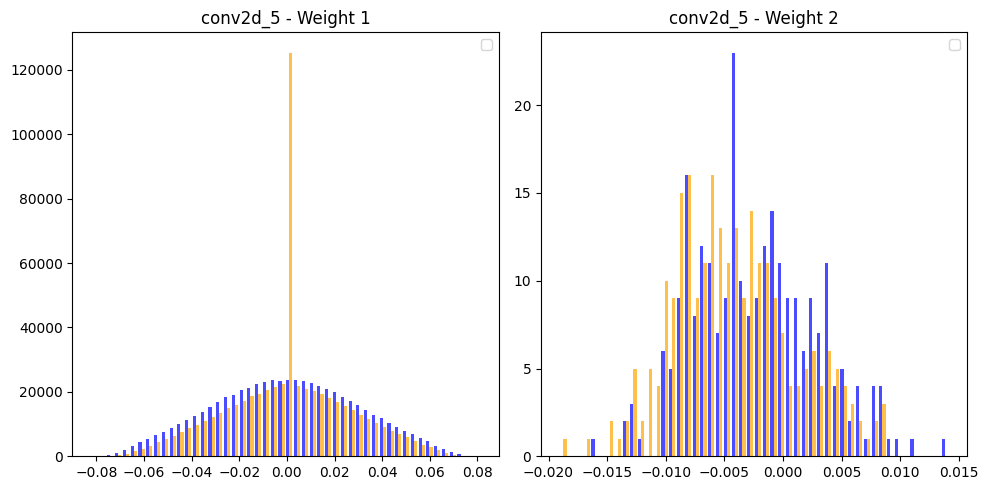

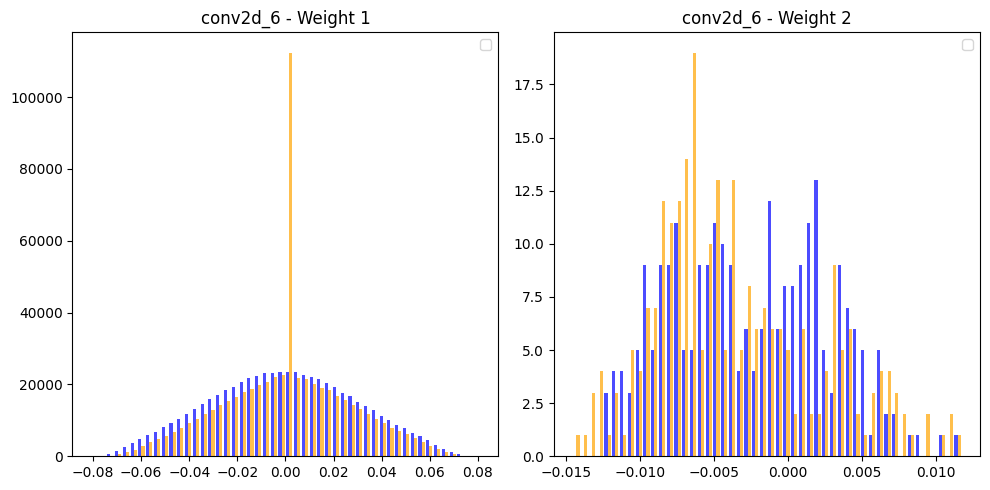

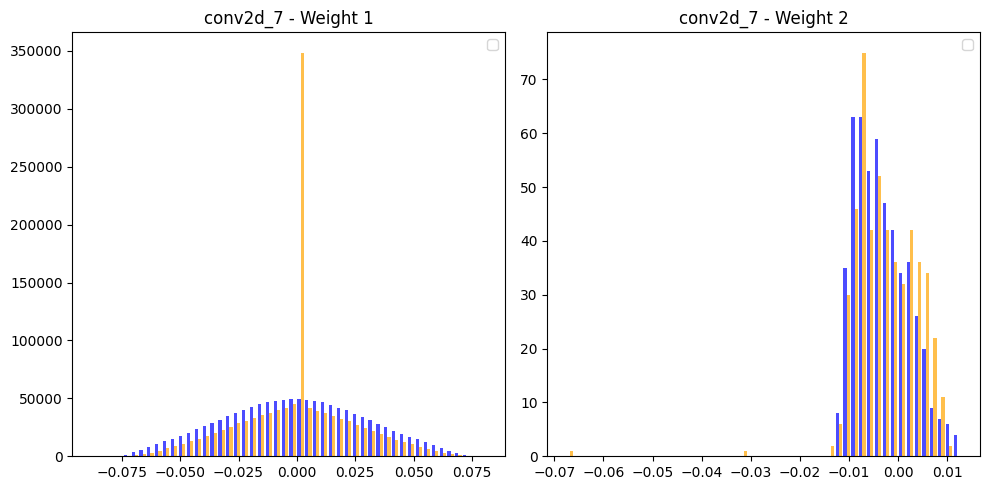

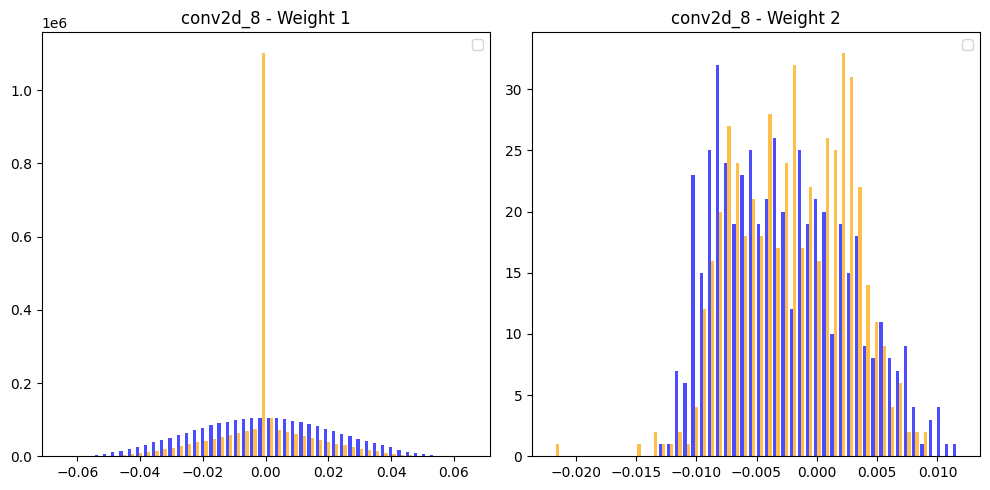

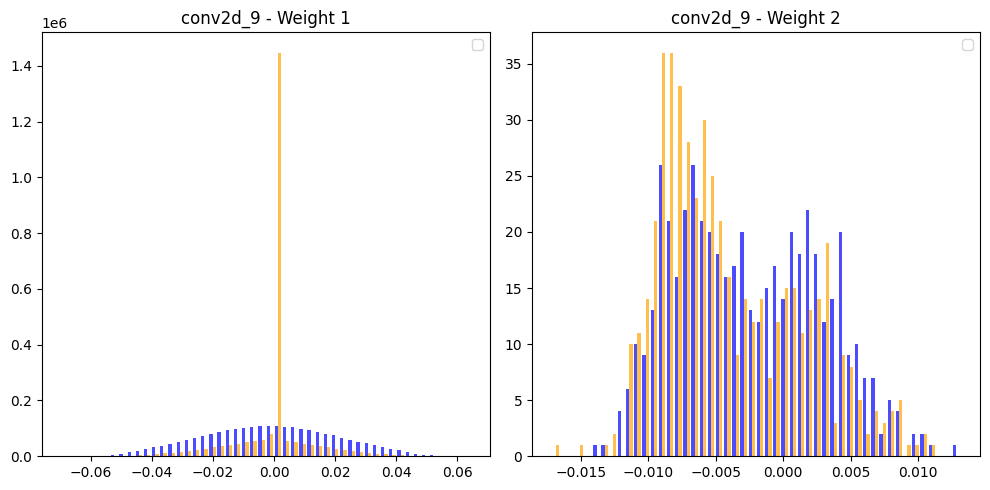

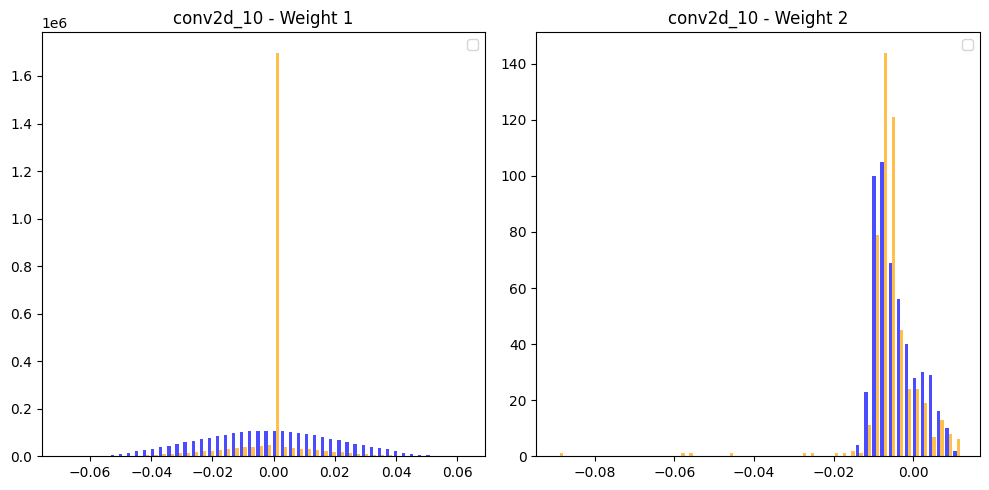

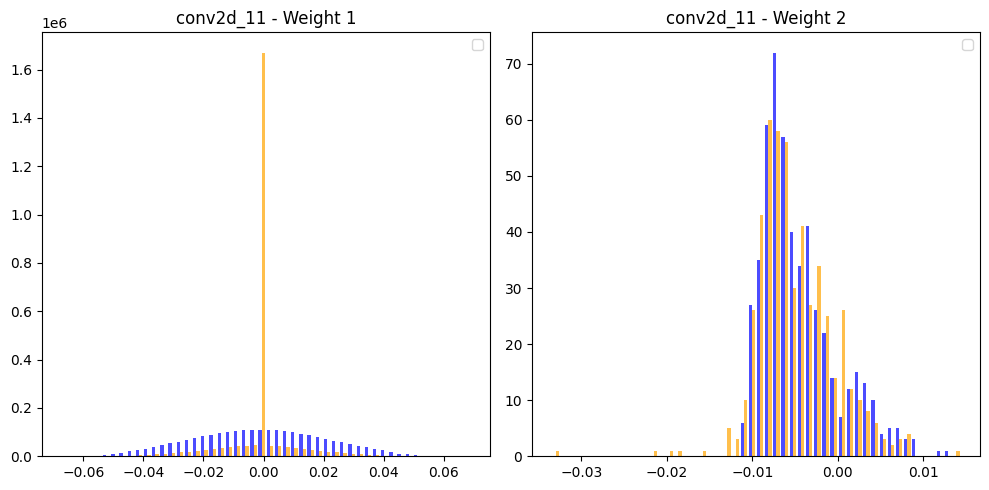

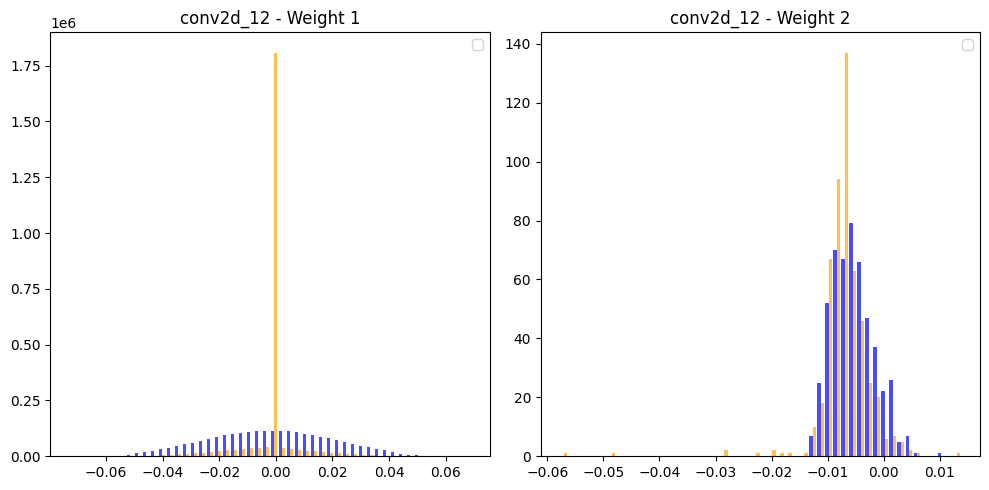

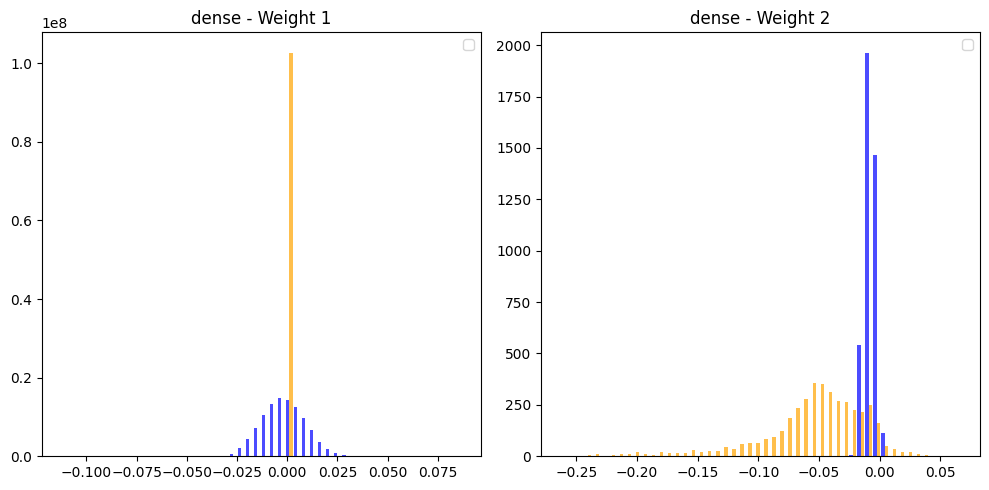

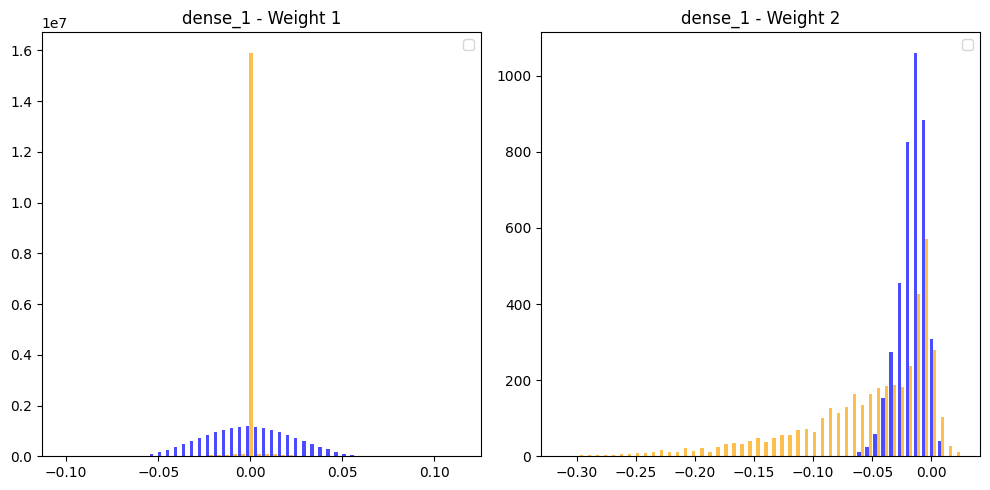

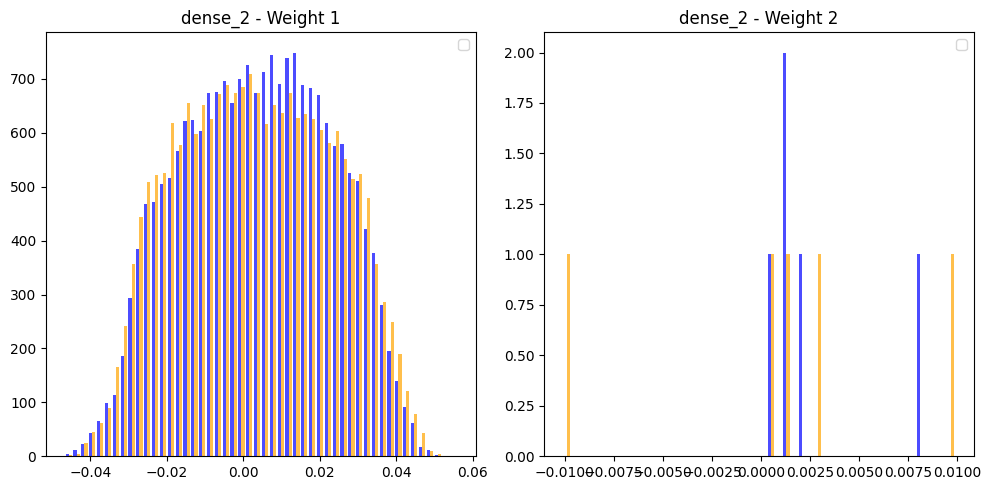

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_weights_histogram(weights1, weights2, layer_name):
    plt.figure(figsize=(10, 5))

    num_weights = len(weights1)

    for i in range(num_weights):
        plt.subplot(1, num_weights, i + 1)
        plt.hist([weights1[i].ravel(), weights2[i].ravel()], bins=50, color=['blue', 'orange'], alpha=0.7)
        plt.title(f'{layer_name} - Weight {i+1}')

    plt.tight_layout()
    plt.show()

# Iterate through layers and compare weights
for layer1, layer2 in zip(my_model.layers, my_model_with_l1.layers):
    weights1 = layer1.get_weights()
    weights2 = layer2.get_weights()

    if len(weights1) > 0:
        plot_weights_histogram(weights1, weights2, layer1.name)

* Based on the results of the regularized and batch normalized models, how effective are L1 or L2 regularization and batch normalization techniques? How do they impact the model's performance, convergence, size, and inference time?
> It's notable that, in the case of L1 regularization, there's no significant improvement, and certain weights remain dominant, potentially contributing to the unbiased classification.

The observation about the long inference time and slow convergence in the absence of batch normalization suggests that the complexity of the model may be causing challenges in training. Batch normalization, as you noted, appears to be advantageous in this context, leading to improved results with the same model complexity and number of epochs.

This underscores the versatility and effectiveness of batch normalization in addressing issues related to convergence and model training. The trade-offs between regularization techniques and normalization methods depend on the specific characteristics of the data and the model architecture. It's encouraging that batch normalization has proven beneficial in your case, demonstrating its advantage in achieving better results under certain conditions.




* How do the learned weights of the L1 or L2 regularized models compare to the baseline model? Provide any insights on the differences in the learned weights and what it implies for the model's performance and interpretability?
> L1 regularization, by encouraging sparsity in weights, tends to push many weights toward zero, effectively selecting features and contributing to a more interpretable model.

However, it's noteworthy that, despite the feature selection attempt, the results obtained from L1 regularization in your case are not satisfactory, even when increasing the number of epochs to 50. This observation underscores the complexity and nuances involved in finding the right balance between regularization strength, model architecture, and training duration.

It might be worthwhile to experiment with different regularization strengths or explore other techniques that could complement or enhance the effects of L1 regularization. Additionally, considering the overall model complexity and the specific characteristics of your data can provide further insights into refining the regularization strategy for improved performance.

* What insights can be drawn from the comprehensive analysis of the regularized and batch normalized models regarding the use of regularization and normalization techniques in training machine learning models?
> Regularization is crucial for preventing overfitting and enhancing the model's generalization performance, especially when the model has high capacity, which can lead to overfitting issues.

On the other hand, batch normalization contributes to learning stability and accelerates convergence by normalizing inputs within each layer during a mini-batch. Your suggestion of combining both regularization and batch normalization is a sound approach. This way, you can leverage the benefits of both techniques to improve model stability, prevent overfitting, and expedite convergence.

Ensembling regularization methods and normalization techniques often proves effective in achieving a well-balanced and high-performing model. Experimenting with the combination of L1 regularization and batch normalization, or exploring other regularization methods alongside batch normalization, could further enhance the overall performance of your model.


In [22]:
#Using Batch Normalization

def my_cnn_model_with_batch_normalization(input_shape=(224, 224, 3), num_classes=5):
    
    model = Sequential()

    # First Block
    model.add(Conv2D(64, (3, 3), activation='selu', padding='same', input_shape=input_shape, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # 2nd Block
    model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # 3rd Block
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # 4th Block
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # 5th Block
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Final FC Block
    model.add(Flatten())
    model.add(Dense(4096, activation='selu', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Dense(4096, activation='selu', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))

    return model
my_model_with_batch_normalization = my_cnn_model_with_batch_normalization()
my_model_with_batch_normalization.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                      

In [23]:
my_model_with_batch_normalization.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

#Training our model
train_model_with_batch_normalization = my_model_with_batch_normalization.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=20, 
    batch_size=32,
)


Epoch 1/20
108/108 [==============================] - 41s 287ms/step - loss: 2.9191 - accuracy: 0.3851 - precision: 0.4137 - recall: 0.3193 - auc: 0.6894 - val_loss: 21.0757 - val_accuracy: 0.3268 - val_precision: 0.3271 - val_recall: 0.3268 - val_auc: 0.5895
Epoch 2/20
108/108 [==============================] - 30s 282ms/step - loss: 1.3987 - accuracy: 0.4904 - precision: 0.5433 - recall: 0.4126 - auc: 0.7941 - val_loss: 3.4406 - val_accuracy: 0.4531 - val_precision: 0.4551 - val_recall: 0.4461 - val_auc: 0.7323
Epoch 3/20
108/108 [==============================] - 30s 283ms/step - loss: 1.2626 - accuracy: 0.5371 - precision: 0.5895 - recall: 0.4569 - auc: 0.8250 - val_loss: 1.9662 - val_accuracy: 0.5388 - val_precision: 0.5414 - val_recall: 0.5156 - val_auc: 0.8040
Epoch 4/20
108/108 [==============================] - 31s 283ms/step - loss: 1.2064 - accuracy: 0.5646 - precision: 0.6168 - recall: 0.4931 - auc: 0.8421 - val_loss: 1.7870 - val_accuracy: 0.5539 - val_precision: 0.5745 - 

In [24]:
eval_result_bn = my_model_with_batch_normalization.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

#Obtain the classification report
y_test_pred_bn = my_model_with_batch_normalization.predict(val_ds, verbose=0)
y_test_pred_classes_bn = np.argmax(y_test_pred_bn, axis=1)

true_labels_bn = []
for _, label in val_ds:
    true_labels_bn.extend(np.argmax(label.numpy(), axis=1))
print("\nClassification Report:")
print(classification_report(true_labels_bn, y_test_pred_classes_bn))

Validation Loss: 1.8092859983444214, Validation Accuracy: 0.3174971044063568

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.73      0.62       147
           1       0.69      0.60      0.64       193
           2       0.56      0.52      0.54       168
           3       0.59      0.85      0.70       149
           4       0.69      0.44      0.54       206

    accuracy                           0.61       863
   macro avg       0.62      0.63      0.61       863
weighted avg       0.62      0.61      0.60       863




ROC-AUC Score: 0.8626985795895304


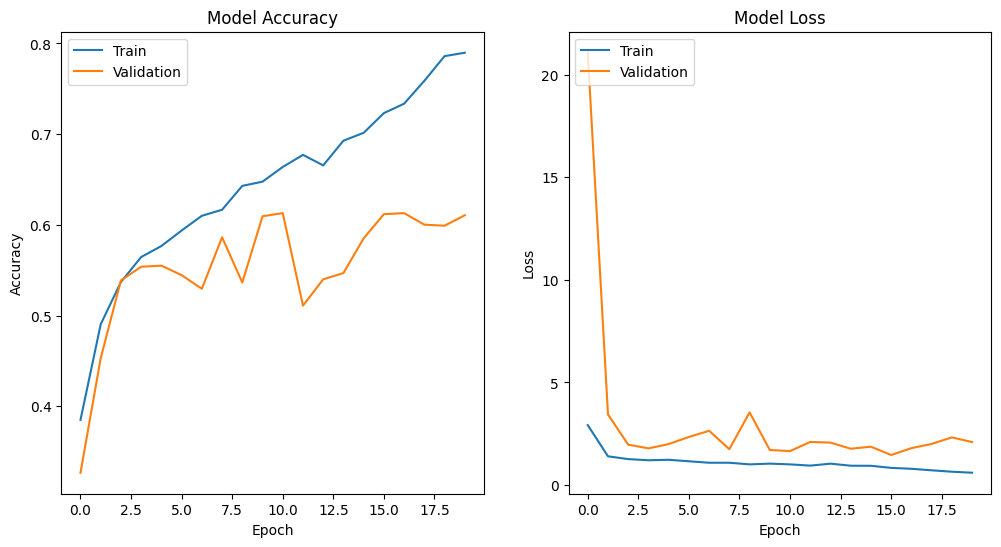

In [25]:
#ROC - AUC 
true_labels_categorical_bn = to_categorical(true_labels_bn, num_classes=5)

roc_auc_bn = roc_auc_score(true_labels_categorical_bn, y_test_pred_bn, multi_class='ovr')
print(f"\nROC-AUC Score: {roc_auc_bn}")

#Progress of our model Training

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(train_model_with_batch_normalization.history['accuracy'])
plt.plot(train_model_with_batch_normalization.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_model_with_batch_normalization.history['loss'])
plt.plot(train_model_with_batch_normalization.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

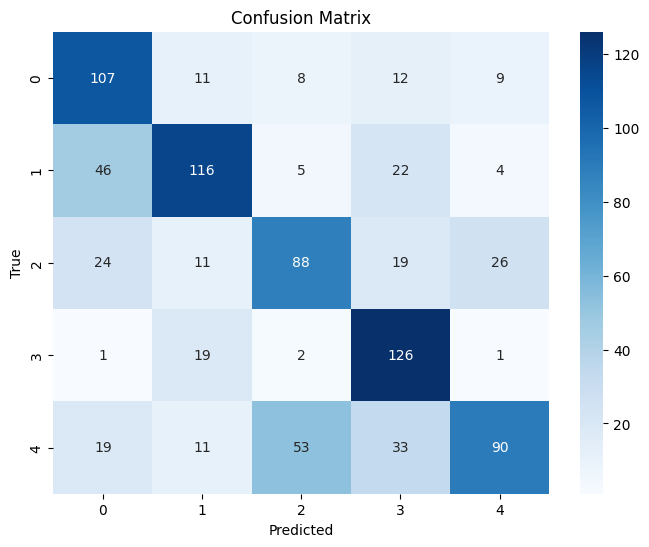

In [26]:

cm = confusion_matrix(true_labels_bn, y_test_pred_classes_bn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels_bn), yticklabels=np.unique(true_labels_bn))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**7. Improve the accuracy by trying something extra** 



* By incorporating additional training strategies such as regularization techniques like dropout, data augmentation, and batch or layer normalization, can the accuracy of the model be improved?
> Let's try and do that, The results are as follows in the blocks below. For this particular case i don't see much of a difference from the previous one, Till this point the output corresponding Batch Normalization seems to be the best.

In [29]:
#Step 7 implementation

def my_cnn_model_with_batch_normalization_data_augumentation(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential()

    # Data augmentation
    data_augmentation = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='selu', padding='same', input_shape=input_shape, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='selu', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='selu', kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create the model with data augmentation
my_cnn_model_with_batch_normalization_data_augumentation = my_cnn_model_with_batch_normalization_data_augumentation()

# Display the model architecture
my_cnn_model_with_batch_normalization_data_augumentation.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_15 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_16 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                      

In [ ]:
tf.keras.backend.clear_session()

In [30]:
my_cnn_model_with_batch_normalization_data_augumentation.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

#Training our model
train_model_with_batch_normalization_data_augumentation = my_cnn_model_with_batch_normalization_data_augumentation.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=32,
)


Epoch 1/20


2023-11-24 00:01:52.101208: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


108/108 [==============================] - 53s 389ms/step - loss: 3.2934 - accuracy: 0.3602 - precision: 0.3772 - recall: 0.3298 - auc: 0.6611 - val_loss: 28.0276 - val_accuracy: 0.3812 - val_precision: 0.3812 - val_recall: 0.3812 - val_auc: 0.6204
Epoch 2/20
108/108 [==============================] - 42s 385ms/step - loss: 1.7768 - accuracy: 0.4464 - precision: 0.4853 - recall: 0.3914 - auc: 0.7515 - val_loss: 4.2189 - val_accuracy: 0.4496 - val_precision: 0.4521 - val_recall: 0.4484 - val_auc: 0.7368
Epoch 3/20
108/108 [==============================] - 42s 385ms/step - loss: 1.6581 - accuracy: 0.4913 - precision: 0.5349 - recall: 0.4302 - auc: 0.7791 - val_loss: 2.1011 - val_accuracy: 0.4519 - val_precision: 0.4678 - val_recall: 0.4287 - val_auc: 0.7768
Epoch 4/20
108/108 [==============================] - 42s 385ms/step - loss: 1.5150 - accuracy: 0.5246 - precision: 0.5620 - recall: 0.4603 - auc: 0.7996 - val_loss: 1.9917 - val_accuracy: 0.4450 - val_precision: 0.4683 - val_recall:

In [31]:
eval_result_bn_da = my_cnn_model_with_batch_normalization_data_augumentation.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

#Obtain the classification report
y_test_pred_bn_da = my_cnn_model_with_batch_normalization_data_augumentation.predict(val_ds, verbose=0)
y_test_pred_classes_bn_da = np.argmax(y_test_pred_bn_da, axis=1)

true_labels_bn_da = []
for _, label in val_ds:
    true_labels_bn_da.extend(np.argmax(label.numpy(), axis=1))
print("\nClassification Report:")
print(classification_report(true_labels_bn_da, y_test_pred_classes_bn_da))

Validation Loss: 1.8092859983444214, Validation Accuracy: 0.3174971044063568

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.73      0.62       147
           1       0.65      0.63      0.64       193
           2       0.58      0.39      0.46       168
           3       0.55      0.82      0.66       149
           4       0.65      0.43      0.52       206

    accuracy                           0.59       863
   macro avg       0.59      0.60      0.58       863
weighted avg       0.60      0.59      0.58       863




ROC-AUC Score: 0.8485856606309433


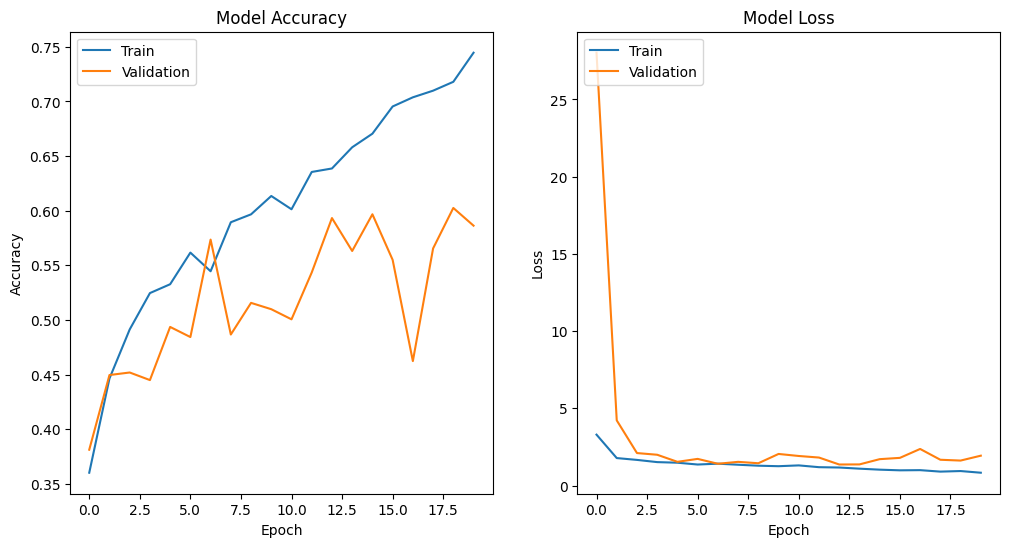

In [32]:
#ROC - AUC 
true_labels_categorical_bn_da = to_categorical(true_labels_bn_da, num_classes=5)

roc_auc_bn_da = roc_auc_score(true_labels_categorical_bn_da, y_test_pred_bn_da, multi_class='ovr')
print(f"\nROC-AUC Score: {roc_auc_bn_da}")

#Progress of our model Training

plt.figure(figsize = (12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(train_model_with_batch_normalization_data_augumentation.history['accuracy'])
plt.plot(train_model_with_batch_normalization_data_augumentation.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_model_with_batch_normalization_data_augumentation.history['loss'])
plt.plot(train_model_with_batch_normalization_data_augumentation.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

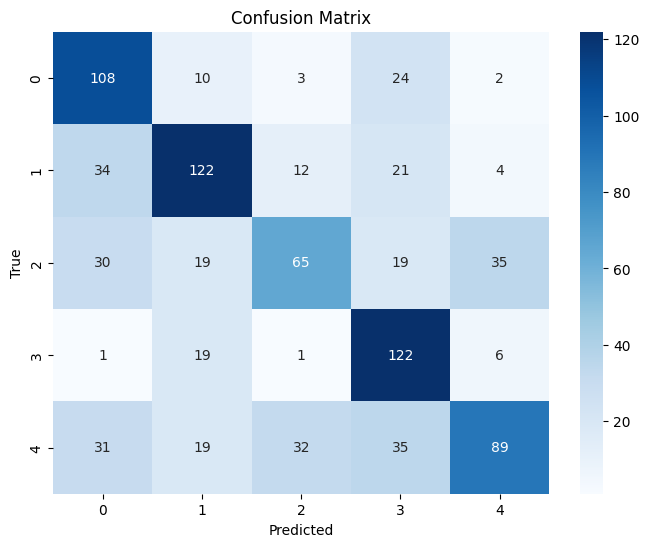

In [33]:
cm = confusion_matrix(true_labels_bn_da, y_test_pred_classes_bn_da)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels_bn_da), yticklabels=np.unique(true_labels_bn_da))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

* Modify the given model architecture to improve the accuracy over the baseline? You can modify the model architecture by adding or removing layers, changing the number of filters, or adding skip connections.
> The observation that the training accuracy of the model is very high while the validation accuracy, though not as good as the training accuracy, is better than using a more complex model is interesting. This scenario suggests that your model might be overfitting to the training data to some extent.

Overfitting occurs when a model learns the training data too well, capturing noise and idiosyncrasies specific to the training set but failing to generalize well to new, unseen data.

The fact that the validation accuracy is better than a more complex model could indicate that your current model strikes a good balance between complexity and generalization. This is a positive outcome, as a model that generalizes well to new data is typically more valuable.

To address overfitting, you might consider further regularization techniques, adjusting model complexity, or exploring methods like dropout during training. These approaches could help your model generalize better to unseen data, potentially improving both training and validation accuracies.

In [34]:
def simplified_cnn_model(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential()

    # Data augmentation
    data_augmentation = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='selu', padding='same', input_shape=input_shape, kernel_initializer='HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer='HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer='HeNormal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='selu', kernel_initializer='HeNormal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model


# Create the simplified model
simplified_model = simplified_cnn_model()

# Display the simplified model architecture
simplified_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_30 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_40 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_31 (Ba  (None, 112, 112, 128)    

In [ ]:
tf.keras.backend.clear_session()

In [35]:
simplified_model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

#Training our model
train_simplified_model = simplified_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=32,
)


Epoch 1/20


2023-11-24 00:17:48.591844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


108/108 [==============================] - 19s 143ms/step - loss: 1.7972 - accuracy: 0.3995 - precision: 0.4397 - recall: 0.3179 - auc: 0.7148 - val_loss: 4.2652 - val_accuracy: 0.3175 - val_precision: 0.3248 - val_recall: 0.3082 - val_auc: 0.6477
Epoch 2/20
108/108 [==============================] - 15s 140ms/step - loss: 1.4376 - accuracy: 0.4925 - precision: 0.5393 - recall: 0.4010 - auc: 0.7858 - val_loss: 1.6231 - val_accuracy: 0.4438 - val_precision: 0.4670 - val_recall: 0.3859 - val_auc: 0.7692
Epoch 3/20
108/108 [==============================] - 15s 140ms/step - loss: 1.1346 - accuracy: 0.5718 - precision: 0.6347 - recall: 0.4855 - auc: 0.8510 - val_loss: 1.9803 - val_accuracy: 0.4380 - val_precision: 0.4513 - val_recall: 0.3917 - val_auc: 0.7457
Epoch 4/20
108/108 [==============================] - 15s 140ms/step - loss: 1.0081 - accuracy: 0.6213 - precision: 0.6829 - recall: 0.5356 - auc: 0.8778 - val_loss: 1.9383 - val_accuracy: 0.4473 - val_precision: 0.4730 - val_recall: 

In [36]:
eval_result_bn_sm = simplified_model.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

#Obtain the classification report
y_test_pred_bn_sm = simplified_model.predict(val_ds, verbose=0)
y_test_pred_classes_bn_sm = np.argmax(y_test_pred_bn_sm, axis=1)

true_labels_bn_sm = []
for _, label in val_ds:
    true_labels_bn_sm.extend(np.argmax(label.numpy(), axis=1))
print("\nClassification Report:")
print(classification_report(true_labels_bn_sm, y_test_pred_classes_bn_sm))

Validation Loss: 1.8092859983444214, Validation Accuracy: 0.3174971044063568

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       147
           1       0.63      0.81      0.71       193
           2       0.64      0.51      0.57       168
           3       0.75      0.79      0.77       149
           4       0.67      0.61      0.64       206

    accuracy                           0.67       863
   macro avg       0.67      0.67      0.67       863
weighted avg       0.67      0.67      0.66       863




ROC-AUC Score: 0.8941415860118601


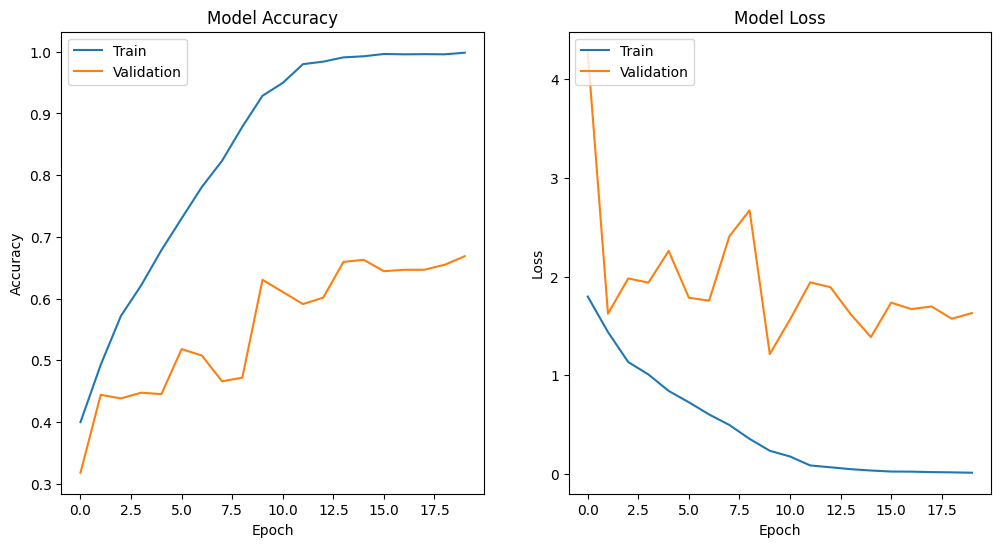

In [37]:
#ROC - AUC 
true_labels_categorical_bn_sm = to_categorical(true_labels_bn_sm, num_classes=5)

roc_auc_bn_sm = roc_auc_score(true_labels_categorical_bn_sm, y_test_pred_bn_sm, multi_class='ovr')
print(f"\nROC-AUC Score: {roc_auc_bn_sm}")

#Progress of our model Training

plt.figure(figsize = (12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(train_simplified_model.history['accuracy'])
plt.plot(train_simplified_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_simplified_model.history['loss'])
plt.plot(train_simplified_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

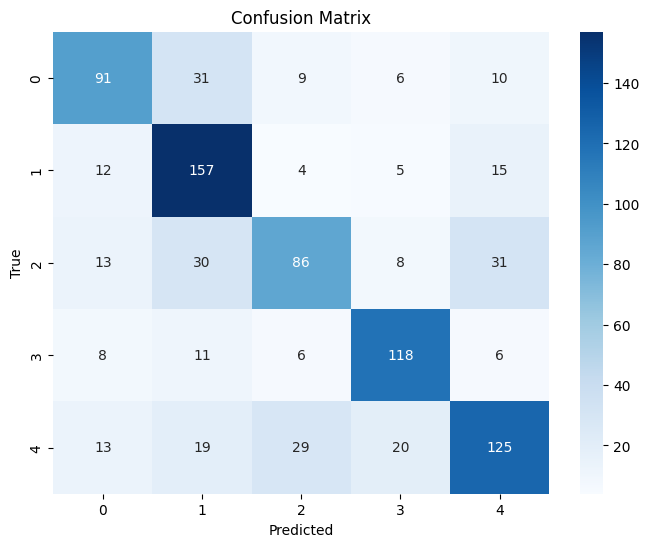

In [38]:
cm = confusion_matrix(true_labels_bn_sm, y_test_pred_classes_bn_sm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels_bn_sm), yticklabels=np.unique(true_labels_bn_sm))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

* Use transfer learning to fine-tune an existing pre-trained model to improve accuracy? What approach will you use for transfer learning: feature extraction or fine-tuning and why?
> Using a pre-trained model like VGG16 for transfer learning in your case is a smart strategy. Pre-trained models, especially those trained on large and diverse datasets, capture a wide range of features that can be beneficial for various computer vision tasks.

In context of classifying flowers, leveraging the learned features from VGG16 can expedite the training process and potentially lead to better generalization. The model has already learned hierarchical representations of features, such as edges, textures, and shapes, from a diverse set of images, including flowers.

By utilizing transfer learning, you can focus on fine-tuning the model on your specific flower dataset, which may be smaller in comparison. This approach often results in improved performance compared to training a model from scratch, especially when you have limited data.

It's a practical and efficient approach, and it's great to leverage the knowledge gained by pre-training on a large dataset to enhance the performance of your model on a more specific task like flower classification.

In [53]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model for fine-tuning
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='selu'))
model.add(Dense(5, activation='softmax')) 

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
#model.fit(
 #   train_ds,
  #  steps_per_epoch=len(train_ds) // 32,
   # epochs=10,  # Adjust the number of epochs based on your requirements
    #validation_data=val_ds,
    #validation_steps=len(val_ds) // 32
#)


In [54]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

#Training our model
train_model = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=32,
)


Epoch 1/50
108/108 [==============================] - 11s 86ms/step - loss: 1.7000 - accuracy: 0.6433 - precision: 0.7029 - recall: 0.5808 - auc: 0.8610 - val_loss: 0.7092 - val_accuracy: 0.7346 - val_precision: 0.7965 - val_recall: 0.6895 - val_auc: 0.9377
Epoch 2/50
108/108 [==============================] - 9s 83ms/step - loss: 0.4156 - accuracy: 0.8477 - precision: 0.8943 - recall: 0.8135 - auc: 0.9785 - val_loss: 0.6607 - val_accuracy: 0.7555 - val_precision: 0.8054 - val_recall: 0.7242 - val_auc: 0.9472
Epoch 3/50
108/108 [==============================] - 9s 82ms/step - loss: 0.2773 - accuracy: 0.8987 - precision: 0.9211 - recall: 0.8790 - auc: 0.9903 - val_loss: 0.6700 - val_accuracy: 0.7856 - val_precision: 0.8123 - val_recall: 0.7625 - val_auc: 0.9501
Epoch 4/50
108/108 [==============================] - 9s 82ms/step - loss: 0.3079 - accuracy: 0.8807 - precision: 0.8978 - recall: 0.8651 - auc: 0.9876 - val_loss: 1.3682 - val_accuracy: 0.6327 - val_precision: 0.6617 - val_reca

In [55]:
eval_result_model = model.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {eval_result_model[0]}, Validation Accuracy: {eval_result_model[1]}")

#Obtain the classification report
y_test_model = model.predict(val_ds, verbose=0)
y_test_pred_classes_model = np.argmax(y_test_model, axis=1)

true_labels_model = []
for _, label in val_ds:
    true_labels_model.extend(np.argmax(label.numpy(), axis=1))
print("\nClassification Report:")
print(classification_report(true_labels_model, y_test_pred_classes_model))

Validation Loss: 0.9642185568809509, Validation Accuracy: 0.8076477646827698

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       147
           1       0.88      0.82      0.85       193
           2       0.80      0.75      0.77       168
           3       0.84      0.83      0.84       149
           4       0.75      0.80      0.77       206

    accuracy                           0.81       863
   macro avg       0.81      0.81      0.81       863
weighted avg       0.81      0.81      0.81       863




ROC-AUC Score: 0.961366412570281


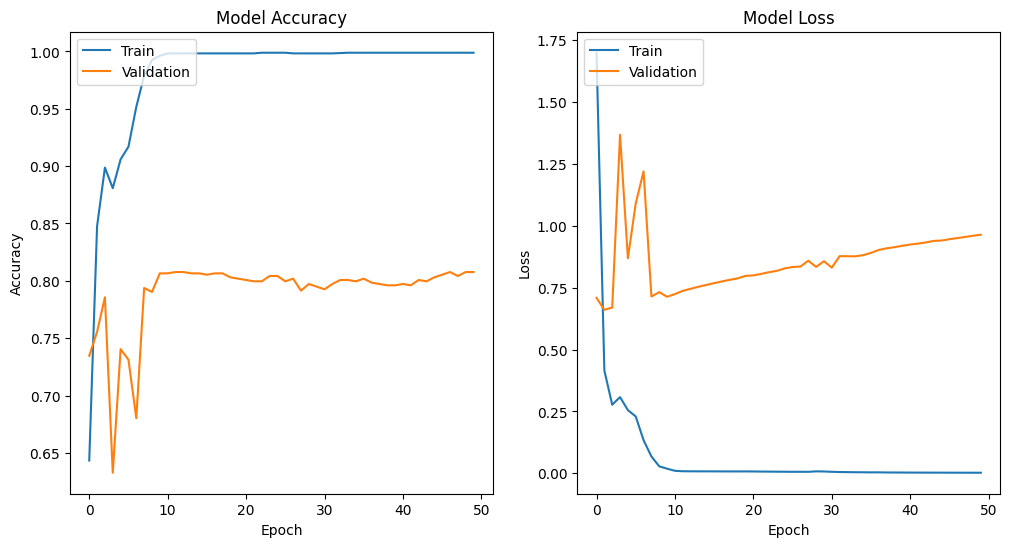

In [56]:
#ROC - AUC 
true_labels_categorical_model = to_categorical(true_labels_model, num_classes=5)

roc_auc_model = roc_auc_score(true_labels_categorical_model, y_test_model, multi_class='ovr')
print(f"\nROC-AUC Score: {roc_auc_model}")

#Progress of our model Training

plt.figure(figsize = (12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

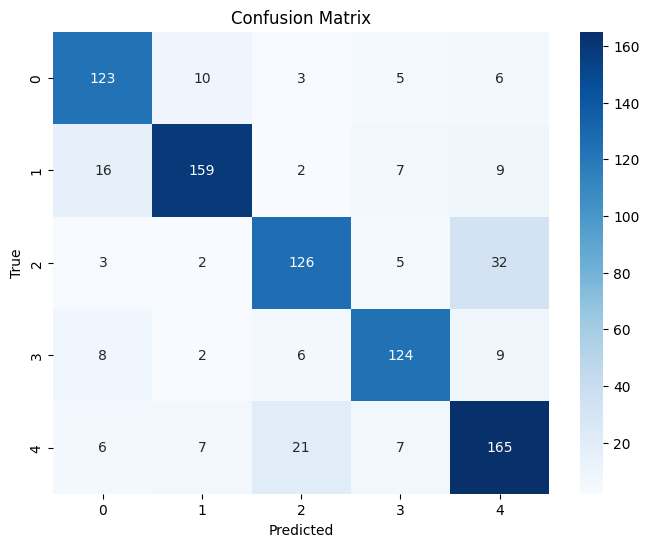

In [57]:
cm = confusion_matrix(true_labels_model, y_test_pred_classes_model)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels_model), yticklabels=np.unique(true_labels_model))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()